# Lab 1

## Module importing

In [1]:
import os
import re

import pandas as pd
import numpy as np
import yaml
import nltk

In [2]:
from pathlib import Path
from typing import Dict, List

from tqdm import tqdm
from collections import Counter, OrderedDict

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

## Settings and useful functions

In [4]:
def get_config(filename: Path) -> Dict:
    with open(filename, 'r') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    return config

In [5]:
PATH2ROOT = Path('')
PATH2DATA = Path(PATH2ROOT / 'data')

## Preparing dataset

In [6]:
def prepare(text: str, do_lower=True) -> str:
    if do_lower:
        text = text.lower()
        
    text = re.sub(r'[^а-яїієґ]|[ыэъё]', '', text)
    
    return text

In [7]:
def read_data(path: Path, do_prepare: bool = True) -> Dict[str, Dict]:
    data = dict()
    
    for author in os.listdir(path):
        data[author] = {'texts': []}
        for filename in os.listdir(path / author):
            if not filename.endswith('.txt'):
                continue
                
            with open(path / author / filename, 'r') as file:
                text = file.read()
                
            if do_prepare:
                text = prepare(text)
            data[author]['texts'].append({'name': filename, 'text': text})
    return data

In [8]:
data = read_data(PATH2DATA / 'train')
test_data = read_data(PATH2DATA / 'test')

In [9]:
default_freq = pd.read_csv(PATH2DATA / 'ukranian_default_freqs.csv', header=None)
default_freq.columns = ['char', 'freq']
default_freq.char = default_freq.char.apply(lambda x: x.lower())
default_freq = default_freq[default_freq.char != 'ы']

## Preview

In [10]:
preview = pd.DataFrame(columns=['author', 'name', 'length'])

for i, author in enumerate(data.keys()):
    for j, text in enumerate(data[author]['texts']):
        preview = preview.append([{'author': author, 'name': text['name'].split('.')[0], 'length': len(text['text'])}])
preview.reset_index(drop=True)

,author,name,length
0,Іван Котляревський,eneida,369337
1,Іван Котляревський,moskal-charivnyk,31013
2,Іван Котляревський,natalka-poltavka,42803
3,Іван Франко,zakhar-berkut,249131
4,Іван Франко,batkivshchyna,49263
5,Іван Франко,soychyne-krylo,60378
6,Олександр Довженко,maty,8236
7,Олександр Довженко,zacharovana-desna,74350
8,Олександр Довженко,nich-pered-boiem,15418


## Char histogram for each text

In [11]:
def compute_char_freq(text: str) -> OrderedDict:
    char_freq = Counter(text)
    char_freq = {key: val / len(text) for key, val in char_freq.items()}
    char_freq = OrderedDict(sorted(char_freq.items(), key=lambda t: t[0]))
    
    return char_freq

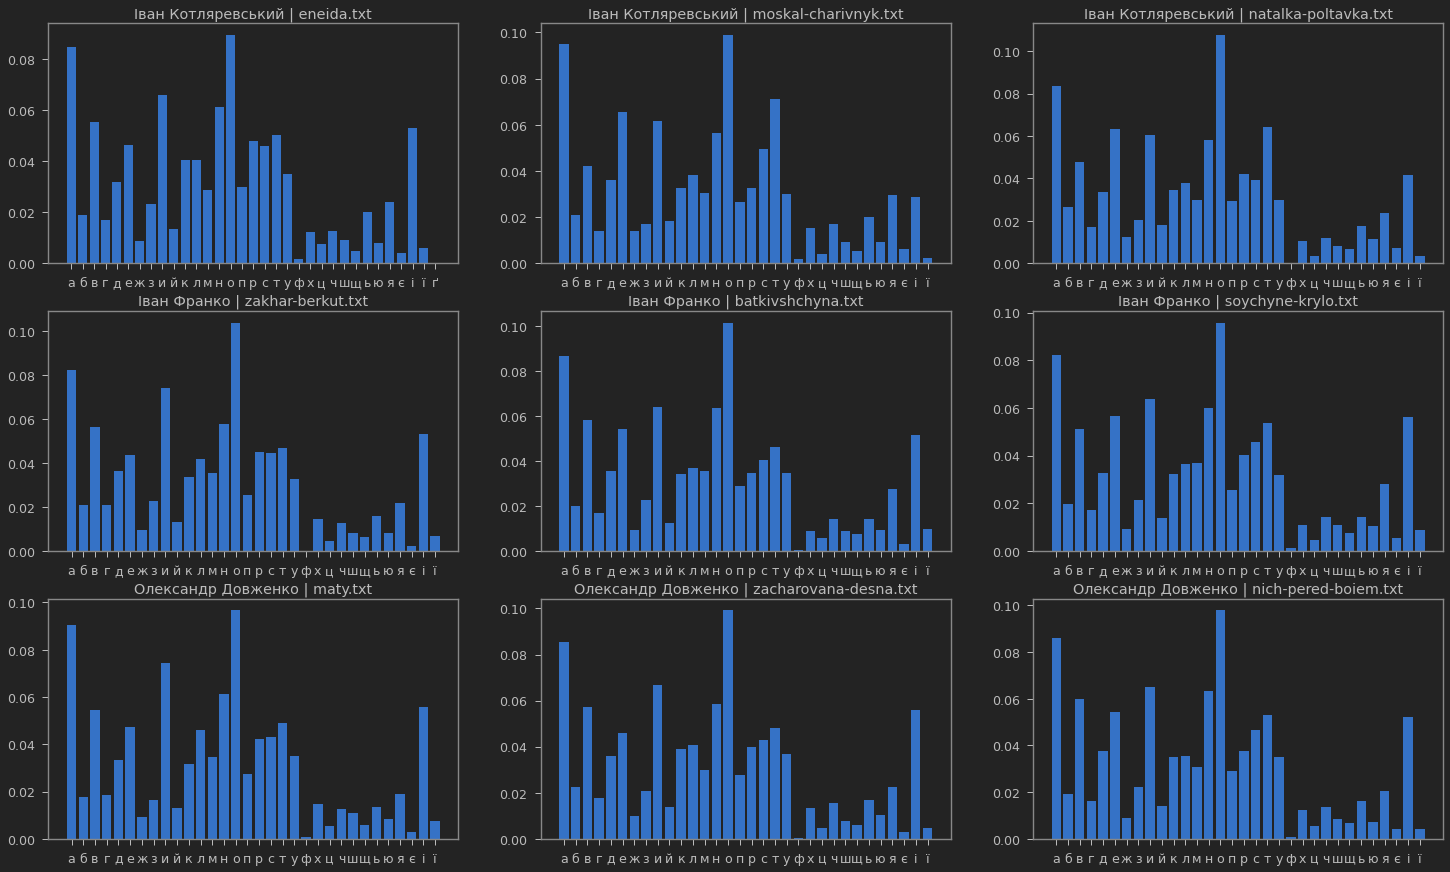

In [12]:
fig, ax = plt.subplots(3,3, figsize=(25,15))

for i, author in enumerate(data.keys()):
    for j, text in enumerate(data[author]['texts']):
        od = compute_char_freq(text['text'])
        ax[i][j].bar(od.keys(), od.values())
        ax[i][j].title.set_text(author + ' | ' + text['name'])

## Char histogram for each author

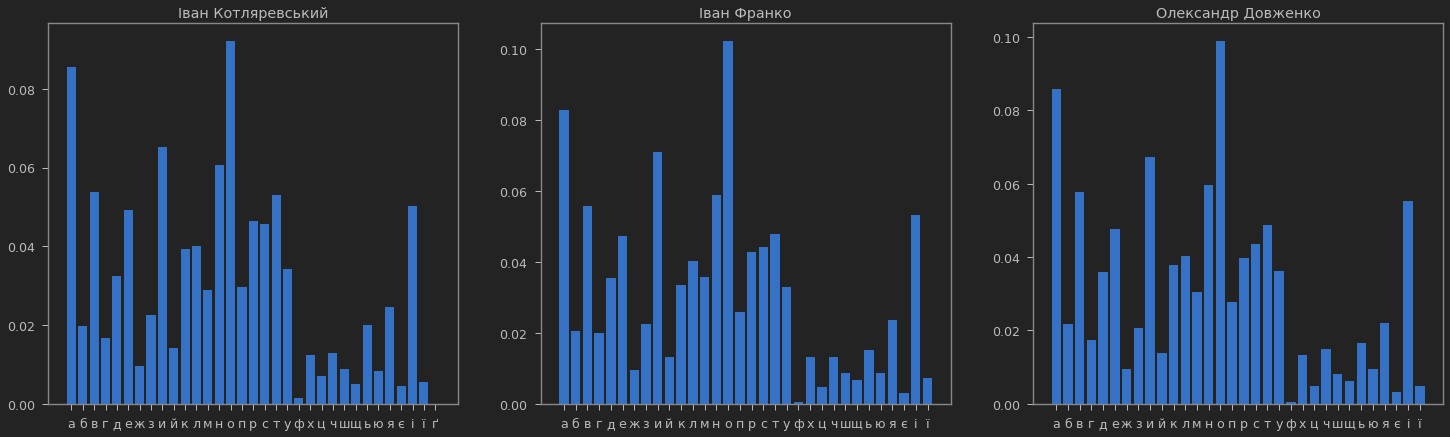

In [13]:
fig, ax = plt.subplots(1,3, figsize=(25,7))

for i, author in enumerate(data.keys()):
    all_texts = ''
    for text in data[author]['texts']:
        all_texts += text['text']
        
    od = compute_char_freq(all_texts)
    ax[i].bar(od.keys(), od.values())
    ax[i].title.set_text(author)

## Bigram frequencies heatmap for each author

In [14]:
def get_all_uniq_chars() -> List:
    return sorted(default_freq.char.values)

In [15]:
def compute_bigram_freq(text: str) -> Counter:
    bigrams = Counter(nltk.bigrams(text))
    
    for key in bigrams.keys():
        bigrams[key] /= np.abs(len(text) - 1)
    return bigrams

In [16]:
CHARS = get_all_uniq_chars()
CHAR2IND = {char: ind for ind, char in enumerate(CHARS)}

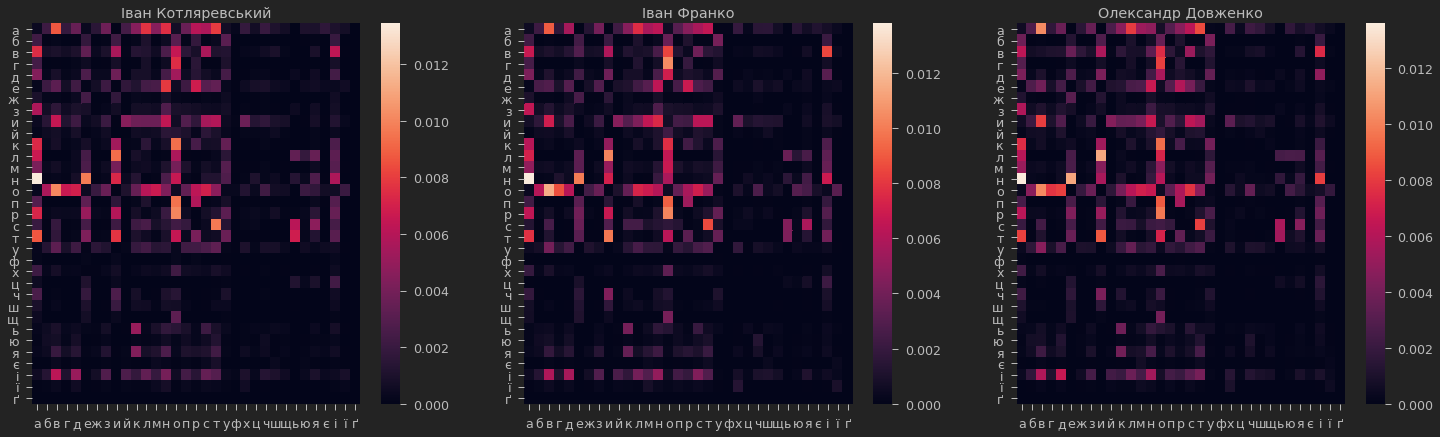

In [37]:
fig, ax = plt.subplots(1,3, figsize=(25,7))

for i, author in enumerate(data.keys()):
    all_texts = ''
    for text in data[author]['texts']:
        all_texts += text['text']
        
    bigrams = compute_bigram_freq(all_texts)
    keys = bigrams.keys()
    
    matrix = np.zeros((len(CHARS), len(CHARS)))
    for key in keys:
        matrix[CHAR2IND[key[0]]][CHAR2IND[key[1]]] = bigrams[key]
    
    sns.heatmap(matrix, ax=ax[i], xticklabels=CHARS, yticklabels=CHARS)
    ax[i].tick_params(labelrotation=0)
    ax[i].title.set_text(author)

## Difference between words frequencies for each text

In [18]:
def compute_char_diff_freq(text: str) -> OrderedDict:
    char_freq = Counter(text)
    char_freq = {key: np.abs(default_freq[default_freq.char == key]['freq'].values[0] - (val / len(text))) for key, val in char_freq.items()}
    char_freq = OrderedDict(sorted(char_freq.items(), key=lambda t: t[0]))
    
    return char_freq

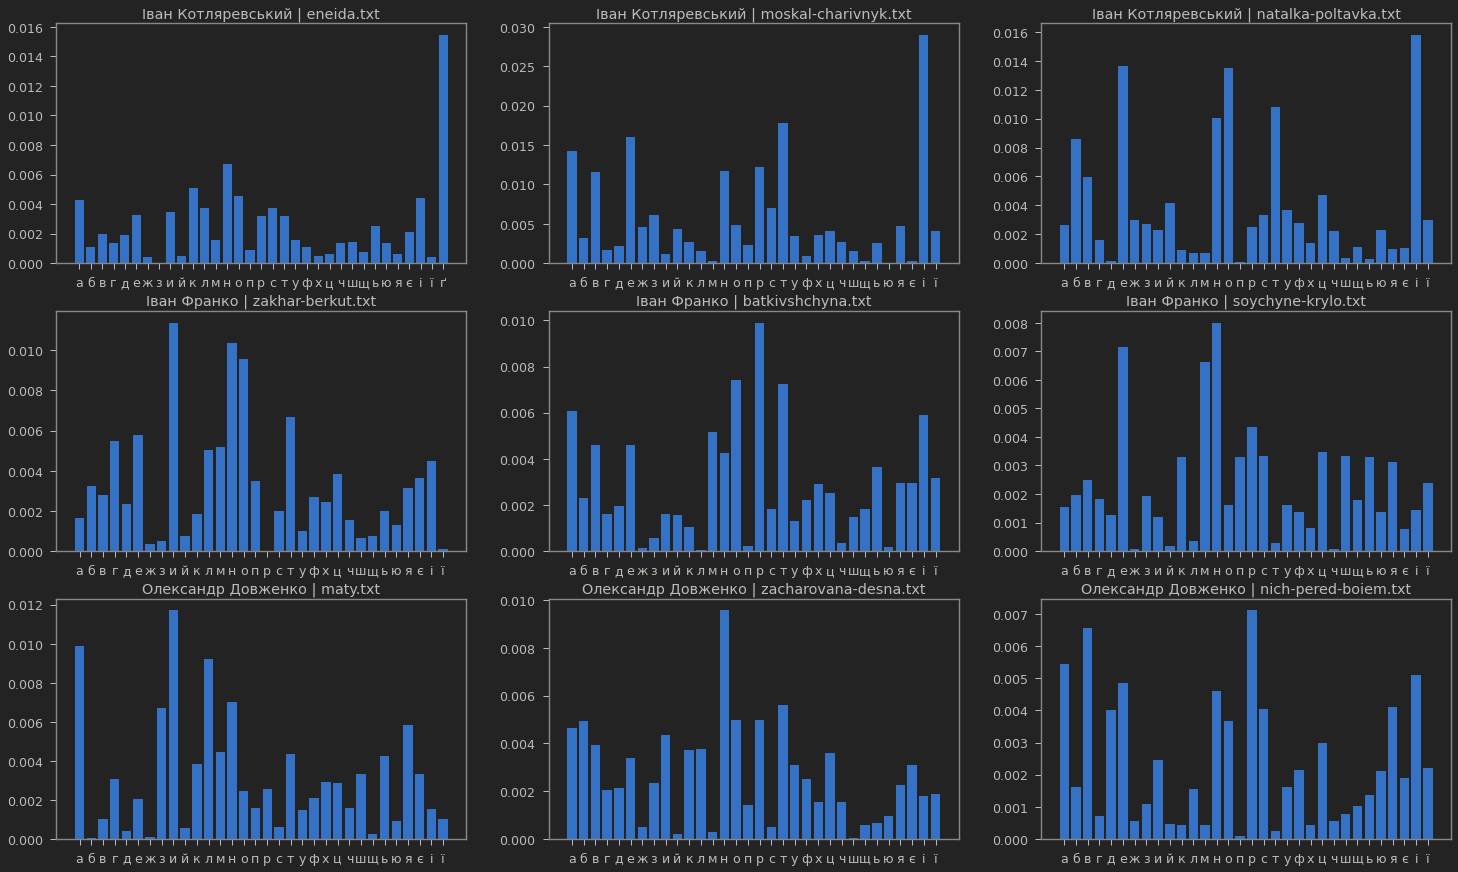

In [40]:
fig, ax = plt.subplots(3,3, figsize=(25,15))

for i, author in enumerate(data.keys()):
    for j, text in enumerate(data[author]['texts']):
        od = compute_char_diff_freq(text['text'])
        ax[i][j].bar(od.keys(), od.values())
        ax[i][j].title.set_text(author + ' | ' + text['name'])

## Difference between words frequencies for each author

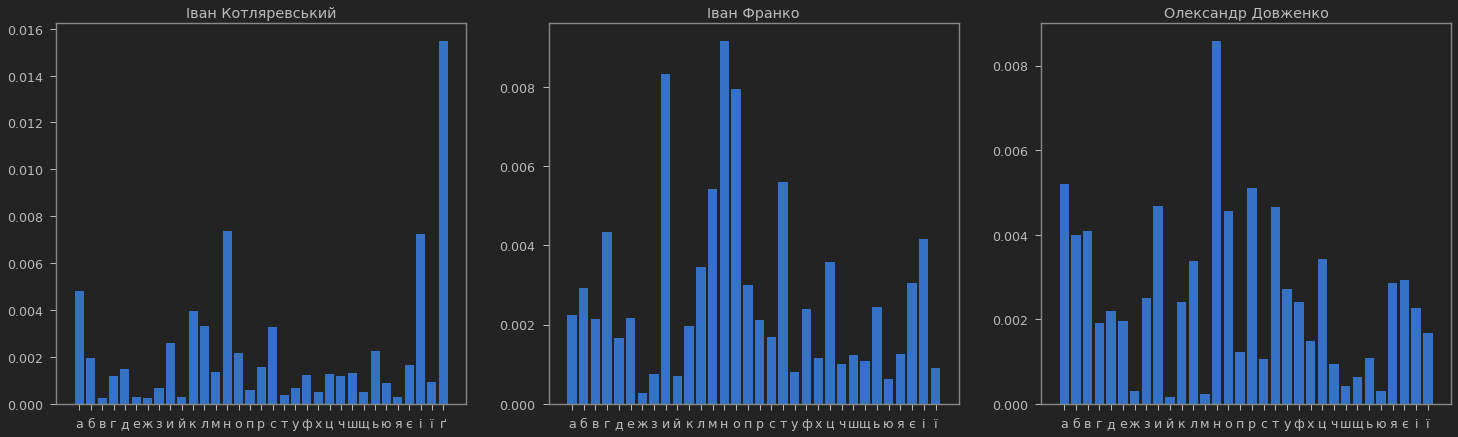

In [41]:
fig, ax = plt.subplots(1,3, figsize=(25,7))

for i, author in enumerate(data.keys()):
    all_texts = ''
    for text in data[author]['texts']:
        all_texts += text['text']
        
    od = compute_char_diff_freq(all_texts)
    ax[i].bar(od.keys(), od.values())
    ax[i].title.set_text(author)

## Difference between bigram frequencies for each author

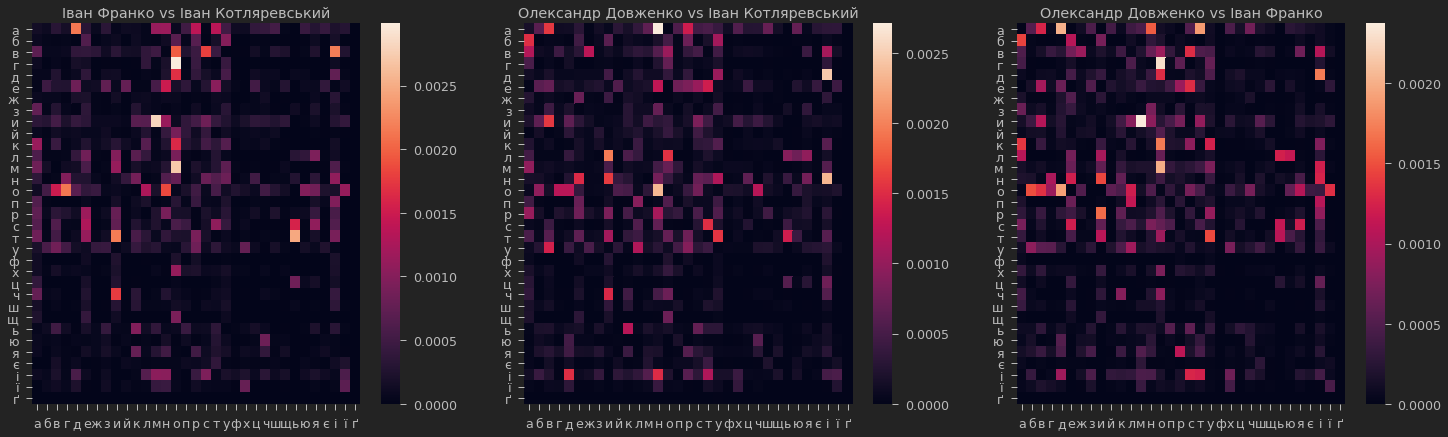

In [36]:
fig, ax = plt.subplots(1,3, figsize=(25,7))

ax_index = 0
for i, author1 in enumerate(data.keys()):
    for j, author2 in enumerate(data.keys()):
        if j >= i:
            continue
            
        all_texts1 = ''
        for text in data[author1]['texts']:
            all_texts1 += text['text']
            
        all_texts2 = ''
        for text in data[author2]['texts']:
            all_texts2 += text['text']

        bigrams1 = compute_bigram_freq(all_texts1)
        keys1 = bigrams1.keys()

        matrix1 = np.zeros((len(CHARS), len(CHARS)))
        for key in keys1:
            matrix1[CHAR2IND[key[0]]][CHAR2IND[key[1]]] = bigrams1[key]
            
        bigrams2 = compute_bigram_freq(all_texts2)
        keys2 = bigrams2.keys()

        matrix2 = np.zeros((len(CHARS), len(CHARS)))
        for key in keys2:
            matrix2[CHAR2IND[key[0]]][CHAR2IND[key[1]]] = bigrams2[key]

        sns.heatmap(np.abs(matrix1 - matrix2), ax=ax[ax_index], xticklabels=CHARS, yticklabels=CHARS)
        ax[ax_index].title.set_text(author1 + ' vs ' + author2)
        ax[ax_index].tick_params(labelrotation=0)
        ax_index += 1

## Prepare result

In [21]:
def compute_char_diff_freq_between_texts(text1: str, text2: str) -> OrderedDict:
    char_freq1 = Counter(text1)
    char_freq2 = Counter(text2)
    char_freq = {key: np.abs((char_freq2[key] / len(text1)) - (char_freq1[key] / len(text2))) for key in char_freq1.keys()}
    char_freq = OrderedDict(sorted(char_freq.items(), key=lambda t: t[0]))
    
    return char_freq

In [22]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [23]:
unigram_result = pd.DataFrame({'chunck_size': [5000, 10000, 25000, 50000, 200000]})
for i, author in enumerate(data.keys()):
    t = pd.DataFrame(columns=['chunck_size', author])
    rows = []
    for chunck in [5000, 10000, 25000, 50000, 200000]:
        all_texts = ''
        for text in data[author]['texts']:
            all_texts += text['text']

        od = compute_char_diff_freq_between_texts(all_texts, test_data['Олександр Довженко']['texts'][0]['text'][:chunck])
        mean_diff = np.mean(list(od.values()))
        rows.append({'chunck_size': chunck, author: mean_diff})
    t = t.append(rows)
    unigram_result = unigram_result.merge(t, on='chunck_size')
    
unigram_result = unigram_result.set_index('chunck_size')

In [24]:
unigram_result.style.apply(highlight_max,axis=1)

,Іван Котляревський,Іван Франко,Олександр Довженко
chunck_size,,,
5000,2.685434,2.241889,0.610931
10000,1.342204,1.120291,0.303074
25000,0.535446,0.446288,0.114534
50000,0.265159,0.219877,0.045311
200000,0.083584,0.065469,0.024535


In [25]:
bigram_result = pd.DataFrame({'chunck_size': [5000, 10000, 25000, 50000, 200000]})

for i, author1 in enumerate(data.keys()):
    t = pd.DataFrame(columns=['chunck_size', author1])
    rows = []
    for chunck in [5000, 10000, 25000, 50000, 200000]:
        all_texts1 = ''
        for text in data[author1]['texts']:
            all_texts1 += text['text']

        bigrams1 = compute_bigram_freq(all_texts1)
        keys1 = bigrams1.keys()

        matrix1 = np.zeros((len(CHARS), len(CHARS)))
        for key in keys1:
            matrix1[CHAR2IND[key[0]]][CHAR2IND[key[1]]] = bigrams1[key]
            
        bigrams2 = compute_bigram_freq(test_data['Олександр Довженко']['texts'][0]['text'][:chunck])
        keys2 = bigrams2.keys()

        matrix2 = np.zeros((len(CHARS), len(CHARS)))
        for key in keys2:
            matrix2[CHAR2IND[key[0]]][CHAR2IND[key[1]]] = bigrams2[key]
        
        rows.append({'chunck_size': chunck, author1: np.abs(matrix1 - matrix2).mean()})
    t = t.append(rows)
    bigram_result = bigram_result.merge(t, on='chunck_size')
    
bigram_result = bigram_result.set_index('chunck_size')

In [26]:
bigram_result.style.apply(highlight_max,axis=1)

,Іван Котляревський,Іван Франко,Олександр Довженко
chunck_size,,,
5000,0.000315,0.000312,0.000303
10000,0.000263,0.000257,0.000250
25000,0.000215,0.000224,0.000215
50000,0.000196,0.000203,0.000192
200000,0.000174,0.000177,0.000161
